<h1><center> <font color='black'> Network Analysis of Scientific Collaboration</font></center></h1>
<h2><center> <font color='black'> Data Preparation & Descriptive Analysis</font></center>

# Data Preparation

# Libraries

In [1]:
# Importing required libraries

import networkx as nx
from networkx.algorithms import community
import pandas as pd
import numpy as np
import itertools
import os
import random
from tqdm import tqdm
import re
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from itertools import cycle, chain

%matplotlib inline

# Loading the data

Loading the data from AMiner-Coauthor

In [2]:
df = pd.read_csv('AMiner-Coauthor.txt', delimiter = "\t", header = None, names=["source", "target", "weight"])
print('Coauthor dataset dimension:', df.shape)
df.head()

Coauthor dataset dimension: (4258946, 3)


,source,target,weight
0,#522324,1034146,1
1,#1355779,1229932,2
2,#688814,947067,2
3,#1329221,1140429,1
4,#742331,314944,1


In [3]:
# Change the column 'source'
df["source"] = (df["source"].str.strip('#').astype(int))

In [4]:
# To check that the data was loadedd correctly
df.head()

,source,target,weight
0,522324,1034146,1
1,1355779,1229932,2
2,688814,947067,2
3,1329221,1140429,1
4,742331,314944,1


In [5]:
# To check the data types of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4258946 entries, 0 to 4258945
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   source  int32
 1   target  int64
 2   weight  int64
dtypes: int32(1), int64(2)
memory usage: 81.2 MB


In [6]:
# To check if there are any NaN values
df.isnull().values.any()

False

In [7]:
# To check if there are any duplicated rows
df.duplicated().sum()

0

In [8]:
# to check if there are any self-loops
for i in range(df.shape[0]):
    if df['source'][i] == df['target'][i]:
        print(i)

Loading the data from AMiner-Author

In [9]:
# Source of this function for preprocessing https://www.kaggle.com/kmader/preprocessing-author-data

with open(os.path.join('AMiner-Author.txt'), 'r', errors='ignore') as f:
    dict_list = []
    c_dict = {}
    for i, line in enumerate(f):
        c_line = line.strip()[1:].strip()
        if len(c_line)<1:
            if len(c_dict)>0:
                dict_list += [c_dict]
            c_dict = {}
        else:
            c_frag = c_line.split(' ')
            c_dict[c_frag[0]] = ' '.join(c_frag[1:])

In [10]:
# Loading the data

author_df = pd.DataFrame(dict_list)
print('Author dataset dimension:', author_df.shape)
author_df.head()

Author dataset dimension: (1712433, 11)


,index,n,a,pc,cn,hi,pi,upi,t,n-2nd,"Valladolid,"
0,1,O. Willum,"Res. Center for Microperipherik, Technische Un...",1,0,0,0.0000,0.0000,new product;product group;active product;long ...,NaN,NaN
1,2,D. Wei,"Dept. of Electr. & Comput. Eng., Drexel Univ.,...",1,0,0,0.0000,0.0000,lowpass filter;multidimensional product filter...,NaN,NaN
2,3,Wenhu Wu,,1,0,0,0.0000,0.0000,MAP adaptation;adaptation data;adaptation utte...,NaN,NaN
3,4,Zhiyuan Zeng,"College of Geography Science, Nanjing Normal U...",1,0,0,0.0000,0.0000,normalized difference vegetation index;ratio v...,NaN,NaN
4,5,Erzen Hyko,"Department of Computer Science, University of ...",1,0,0,0.0000,0.0000,information content;Spatio-Temporal Informatio...,NaN,NaN


In [11]:
# Rename the columns
author_df.rename({'a': 'affiliation',
                 'n': 'author', 
                  'index':'id',
                 'pc': 'papers',
                 'cn': 'citations',
                  'hi': 'h_id',
                  'pi':'p_id',
                  'upi':'up_id',
                  't': 'research'
                 }, axis=1, inplace=True)

# Drop the columns n-2nd and Valladolid,
author_df = author_df[['id', 'author', 'affiliation', 'papers', 'citations', 'h_id', 'p_id', 'up_id','research']]
author_df.head()

,id,author,affiliation,papers,citations,h_id,p_id,up_id,research
0,1,O. Willum,"Res. Center for Microperipherik, Technische Un...",1,0,0,0.0000,0.0000,new product;product group;active product;long ...
1,2,D. Wei,"Dept. of Electr. & Comput. Eng., Drexel Univ.,...",1,0,0,0.0000,0.0000,lowpass filter;multidimensional product filter...
2,3,Wenhu Wu,,1,0,0,0.0000,0.0000,MAP adaptation;adaptation data;adaptation utte...
3,4,Zhiyuan Zeng,"College of Geography Science, Nanjing Normal U...",1,0,0,0.0000,0.0000,normalized difference vegetation index;ratio v...
4,5,Erzen Hyko,"Department of Computer Science, University of ...",1,0,0,0.0000,0.0000,information content;Spatio-Temporal Informatio...


In [12]:
# To check if there are any duplicated rows
author_df.duplicated().sum()

0

In [13]:
# Check the types of data
author_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1712433 entries, 0 to 1712432
Data columns (total 9 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   id           object
 1   author       object
 2   affiliation  object
 3   papers       object
 4   citations    object
 5   h_id         object
 6   p_id         object
 7   up_id        object
 8   research     object
dtypes: object(9)
memory usage: 117.6+ MB


In [14]:
# To check for missing values
print('The number of missing values in "Author"',author_df["author"].isnull().sum())
print('The number of missing values in "Papers"',author_df["papers"].isnull().sum())
print('The number of missing values in "Citations"',author_df["citations"].isnull().sum())
print('The number of missing values in "Index"',author_df["id"].isnull().sum())
print('The number of missing values in "Research"',author_df["research"].isnull().sum())

The number of missing values in "Author" 0
The number of missing values in "Papers" 0
The number of missing values in "Citations" 0
The number of missing values in "Index" 0
The number of missing values in "Research" 0


In [15]:
# Change the data type of columns 'id', 'papers', 'citations', 'h_id', 'p_id', 'up_id'

author_df[['id', 'papers', 'citations', 'h_id', 'p_id', 'up_id']] = author_df[['id', 'papers', 'citations', 'h_id', 'p_id', 'up_id']].apply(pd.to_numeric)

In [16]:
# for nodes change the index
nodes_df = author_df.set_index(['id'])
nodes_df.head()

,author,affiliation,papers,citations,h_id,p_id,up_id,research
id,,,,,,,,
1,O. Willum,"Res. Center for Microperipherik, Technische Un...",1,0,0,0.0,0.0,new product;product group;active product;long ...
2,D. Wei,"Dept. of Electr. & Comput. Eng., Drexel Univ.,...",1,0,0,0.0,0.0,lowpass filter;multidimensional product filter...
3,Wenhu Wu,,1,0,0,0.0,0.0,MAP adaptation;adaptation data;adaptation utte...
4,Zhiyuan Zeng,"College of Geography Science, Nanjing Normal U...",1,0,0,0.0,0.0,normalized difference vegetation index;ratio v...
5,Erzen Hyko,"Department of Computer Science, University of ...",1,0,0,0.0,0.0,information content;Spatio-Temporal Informatio...


In [17]:
# to later add attributes to nodes
nodes_attributes = nodes_df.to_dict('index')

# Creating the network

In [18]:
G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr=True)
nx.set_node_attributes(G, nodes_attributes)
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 1560640\nNumber of edges: 4258946\nAverage degree:   5.4579'

In [19]:
# To check if the network is connected
print(nx.is_connected(G))

False


In [20]:
# Check the number of connected components in the network
nx.number_connected_components(G)

156240

In [21]:
node_sets = list(nx.connected_components(G))
nn = []
for i in node_sets:
    nn.append(len(i))

In [22]:
# Five largest components
nn.sort(reverse=True)
print(nn[0])
print(nn[1])
print(nn[2])
print(nn[3])
print(nn[4])

1057194
83
73
72
71


# Creating the network of scientists with research interests in Computer Science

In [23]:
selected_nodes = [n for n,v in G.nodes(data=True) if 'computer science' in v['research']]

In [24]:
G_sub = G.subgraph(selected_nodes)
nx.info(G_sub)

'Name: \nType: Graph\nNumber of nodes: 5258\nNumber of edges: 7891\nAverage degree:   3.0015'

In [25]:
# To check if the network is connected
print(nx.is_connected(G_sub))

False


In [26]:
Gcc = sorted(nx.connected_components(G_sub), key=len, reverse=True)
G_data = G.subgraph(Gcc[0])
nx.info(G_data)

'Name: \nType: Graph\nNumber of nodes: 1707\nNumber of edges: 4923\nAverage degree:   5.7680'

In [27]:
# To check if the network is connected
print(nx.is_connected(G_data))

True


# Descriptive analysis 

Text(0.5, 0, 'Degree')

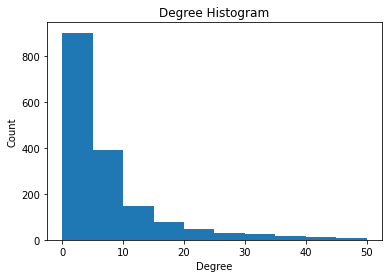

In [28]:
#Degree plot
degrees = [G_data.degree(n, weight='weight') for n in G_data.nodes()]
plt.hist(degrees, range = (0, 50))
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")

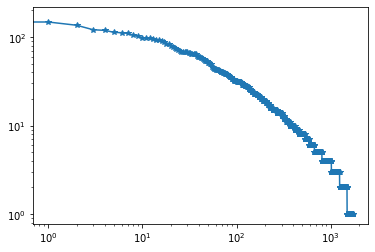

In [29]:
degree_sequence = sorted([d for n, d in G_data.degree(weight='weight')], reverse=True)
plt.loglog(degree_sequence,marker='*')
plt.show()

In [30]:
# Graph transitivity, the fraction of all possible triangles present in G.
nx.transitivity(G_data)

0.285031708800278

In [31]:
# Edge density, the ratio of existing edges over possible ones. For complete graph it is equal to 1.
nx.density(G_data)

0.00338101644768696

In [32]:
# Clustering coefficient,how clustered the network is (what fraction of the nodes are connected on average)
nx.average_clustering(G_data, weight = 'weight')

0.029457995756242583

In [33]:
# Diameter, the longest distance between two nodes (the maximum length of shortest length)
nx.diameter(G_data)

13

In [34]:
# Average path length, the average of the shortest paths for all pairs of nodes. 
nx.average_shortest_path_length(G_data, weight = 'weight')

6.384910488568209

Centrality

In [35]:
# Degree centrality
degree = G_data.degree(weight='weight')
max_degree = max(dict(degree).values())

degree_c = pd.DataFrame(index=range(1707), columns=['node', 'author', 'centrality'])

for i in range(1707): # the number of nodes
    degree_c.loc[i,'node'] = list(degree)[i][0]
    degree_c.loc[i,'author'] = G_data.nodes[degree_c.loc[i,'node']]['author']  
    degree_c.loc[i,'centrality'] = list(degree)[i][1]/max_degree

degree_c = degree_c.sort_values(by='centrality', ascending=False)

degree_c.head()

,node,author,centrality
187,910242,Robert David McCartney,1.0
1577,490858,Kathryn E. Sanders,0.865497
543,1174026,Mark Guzdial,0.795322
1441,244431,Beth Simon,0.707602
730,126337,Lynda Thomas,0.695906


In [36]:
# Closeness centrality

G_distance_dict = {(e1, e2): 1 / weight for e1, e2, weight in G_data.edges(data='weight')}

nx.set_edge_attributes(G_data,G_distance_dict, 'distance')
closeness_centrality = nx.closeness_centrality(G_data, distance='distance')

for node in sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)[:5]:
    print(node,G_data.nodes[node]['author'], closeness_centrality[node])

1262548 John Impagliazzo 0.49332894959470275
1201617 Henry M Walker 0.48968000486939783
431339 Deborah L. Knox 0.4869744471603487
1174026 Mark Guzdial 0.48600301591627587
1481761 Owen Astrachan 0.4852329346844629


In [37]:
# Eigenvector centrality
eigenvector_centrality_weighted = nx.eigenvector_centrality(G_data, weight='weight')

for node in sorted(eigenvector_centrality_weighted, key=eigenvector_centrality_weighted.get, reverse=True)[:5]:
    print(node, G_data.nodes[node]['author'], eigenvector_centrality_weighted[node])

910242 Robert David McCartney 0.46823219679197375
490858 Kathryn E. Sanders 0.42532092326817106
1246704 Carol Sue Zander 0.3446818791084551
126337 Lynda Thomas 0.3108467172189892
130150 Anna Eckerdal 0.29098905407244385


In [38]:
# Betweenness centrality
betweenness_centrality_weighted = nx.betweenness_centrality(G_data, weight='weight')

#Sort for identifying most inflential nodes using betweenness centrality
for node in sorted(betweenness_centrality_weighted, key=betweenness_centrality_weighted.get, reverse=True)[:5]:
    print(node, G_data.nodes[node]['author'], betweenness_centrality_weighted[node])

331047 N. B. Dale 0.09178785340422166
1481761 Owen Astrachan 0.09009610615778506
1174026 Mark Guzdial 0.08559263481607282
392161 Ursula Wolz 0.08496052325046012
1088800 Joyce Currie Little 0.06851735028954954


In [39]:
# Pagerank
pagerank = nx.pagerank(G_data, weight='weight')

for node in sorted(pagerank, key=pagerank.get, reverse=True)[:5]:
    print(node,G_data.nodes[node]['author'], pagerank[node])

1174026 Mark Guzdial 0.006334169064114092
1151075 Gerald L. Engel 0.004861331633849172
467782 Susan Rodger 0.004831532009258194
331047 N. B. Dale 0.004683186467170081
910242 Robert David McCartney 0.00462634623527315


# From the network get the csv file

In [40]:
df_cc = nx.to_pandas_edgelist(G_data, source='source', target='target')
df_cc = df_cc.drop(columns = ['distance'])
print('Dimentions', df_cc.shape)
df_cc.head()

Dimentions (4923, 3)


,source,target,weight
0,1605636,64684,1
1,1605636,1343349,1
2,1605636,1352169,1
3,1605636,451036,1
4,1605636,569658,1


In [41]:
df_cc.to_csv('df_cc.csv', index=False)